# Aspect based sentiment analyses part_02

## Постановка задачи

Сделать небольшое EDA и оценить качество разметки gpt-4

## Выводы

- преобладают позитивные аспекты 69% против негативных 21%
- топ 5 популярных аспектов
  
|aspect | percentage|
|--|--|
| расположение| 75%|
|персонал |57% |
| завтрак|48% |
|общее впечатление | 43%|
| номер| 42%|

- совпадение ацессора и gpt-4
  - 100% полнота
  - 100% точность

## Imports

In [4]:
from pathlib import Path
import pandas as pd

## Initialization

In [3]:
def find_project_root() -> Path:

    start_path = Path.cwd()
    for parent in start_path.parents:
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists() or (parent / "setup.py").exists():
            return parent
    return start_path  # Fallback: if no marker is found, return the original path


# Get the project root automatically
PROJECT_ROOT = find_project_root()
print(Path.cwd())

d:\Projects\finam_hotel_reviews\notebooks


## Read data

In [7]:
df_initial = pd.read_excel(PROJECT_ROOT / "data" / "interim" / "200_labeled_gpt_4.xlsx")
df_initial.head(2)

,Unnamed: 0,review_id,text,labels
0,0,1,Это был самый маленький по площади номер из вс...,"[{'aspect': 'размер номера', 'sentiment': 'neg..."
1,1,2,Понравилось всё!!! От персонала до оснащения н...,"[{'aspect': 'персонал', 'sentiment': 'positive..."


In [31]:
df_initial.shape

(200, 4)

## Some stats and tiny EDA on 200 reviews

In [42]:
ls_labels = df_initial["labels"].to_list()

ls_aspect = []
ls_sentiment = []

for label in ls_labels:
    label_json = json.loads(label.replace("'", '"'))
    for aspect in label_json:
        ls_aspect.append(aspect["aspect"])
        ls_sentiment.append(aspect["sentiment"])

In [ ]:
df_stat = pd.DataFrame({"aspect": ls_aspect, "sentiment": ls_sentiment})
df_stat.head(3)

,aspect,sentiment
0,размер номера,negative
1,уют,positive
2,комфорт,positive


In [45]:
len(df_stat)

1571

In [46]:
sentiment_counts = df_stat["sentiment"].value_counts()
print(sentiment_counts)

sentiment
positive    1085
negative     341
mixed         82
neutral       63
Name: count, dtype: int64


In [48]:
aspect_counts = df_stat.groupby("aspect")["sentiment"].value_counts().unstack(fill_value=0)
aspect_counts

sentiment,mixed,negative,neutral,positive
aspect,,,,
best western,0,0,0,1
reception,0,0,1,0
wi-fi,1,9,1,10
wifi,0,2,0,2
администратор,0,0,1,0
...,...,...,...,...
электрочайник,0,0,0,1
эхо в номере,0,1,0,0
языковая поддержка,0,0,0,1


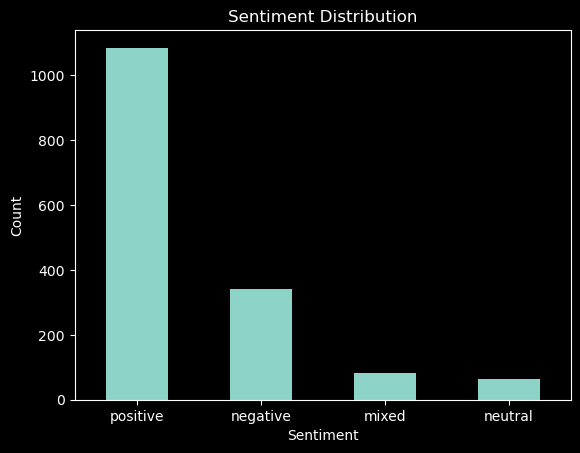

In [49]:
import matplotlib.pyplot as plt

# Bar chart of sentiment counts
sentiment_counts.plot(kind="bar", title="Sentiment Distribution", rot=0)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

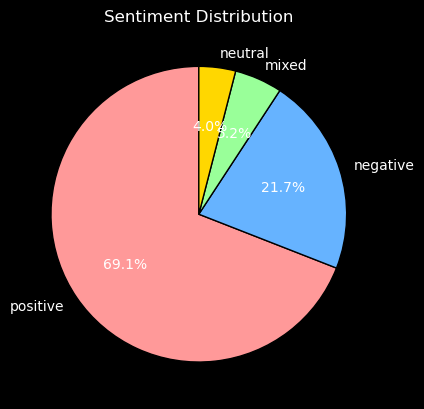

In [67]:
import matplotlib.pyplot as plt

# Define custom colors

custom_colors = ["#FF9999", "#66B3FF", "#99FF99", "#FFD700"]  # Red, Blue, Green, Gold

# Create Pie Chart with custom colors
sentiment_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    title="Sentiment Distribution",
    colors=custom_colors,  # Apply custom colors
    startangle=90,  # Rotate start position
    wedgeprops={"edgecolor": "black"},  # Add border for better visibility
)

plt.ylabel("")  # Hide y-label for cleaner look
plt.show()

In [51]:
from collections import Counter

cnt_stat = Counter(ls_aspect)

In [57]:
dict_stat = cnt_stat.most_common(10)
dict_stat

[('расположение', 150),
 ('персонал', 114),
 ('завтрак', 97),
 ('общее впечатление', 86),
 ('номер', 83),
 ('чистота', 54),
 ('цена', 49),
 ('удобства в номере', 28),
 ('обслуживание', 22),
 ('wi-fi', 21)]

In [63]:
import math

dict_stat_percent = {k: (str(round((v / 200) * 100)) + "%") for k, v in dict_stat}
dict_stat_percent

{'расположение': '75%',
 'персонал': '57%',
 'завтрак': '48%',
 'общее впечатление': '43%',
 'номер': '42%',
 'чистота': '27%',
 'цена': '24%',
 'удобства в номере': '14%',
 'обслуживание': '11%',
 'wi-fi': '10%'}

## Оценим точность: GPT-4 vs accessor

In [65]:
df_initial.sample(5).to_excel(PROJECT_ROOT / "data" / "interim" / "5_samples.xlsx")

В файле сделаны ручные оценки полноты и точности, уровень совпадения gpt-4 и  ацессора 100%.
Ацессором выступал автор ноутбука.

## Пример таксмонии оценки отзывов

In [88]:
import plotly.graph_objects as go

# Define taxonomy structure
categories = {
    "Локация и транспорт": {
        "Расположение": ["Достопримечательности", "Парки", "Центр города"],
        "Транспортная доступность": ["Автобусы", "Метро", "Такси"],
        "Парковка": ["Охраняемая", "Платная", "Бесплатная"],
    },
    "Обслуживание и персонал": {
        "Персонал": ["Доброжелательность", "Компетентность"],
        "Сервис": ["Скорость обслуживания", "Реакция на жалобы"],
        "Гостеприимство": ["Приветствие", "Помощь гостям"],
        "Бронирование": ["Онлайн", "Через звонок"],
    },
    "Цена и качество": {
        "Цена": ["Высокая", "Средняя", "Низкая"],
        "Соотношение цена/качество": [],
        "Выбор отеля": [],
    },
    "Комфорт и удобства": {
        "Размер номера": ["Маленький", "Средний", "Просторный"],
        "Мебель": ["Современная", "Старая"],
        "Кондиционер": ["Работает", "Не работает"],
        "Звукоизоляция": ["Плохая"],
    },
    "Чистота и гигиена": {
        "Чистота номера": ["Пыль", "Запах", "Чистая"],
        "Уборка": ["Ежедневная", "Редкая"],
        "Сантехника": ["Исправная", "Неисправная"],
        "Безопасность": ["Камеры", "Охрана"],
    },
    "Питание": {
        "Завтрак": ["Шведский стол", "Континентальный"],
        "Качество еды": ["Свежая", "Несвежая"],
        "Ресторан": ["Разнообразие блюд", "Обслуживание"],
    },
    "Атмосфера и интерьер": {
        "Интерьер": ["Современный", "Классический"],
        "Атмосфера": ["Уютная", "Безликая"],
        "Дизайн": ["Минимализм"],
    },
    "Технические удобства": {
        "Wi-Fi": ["Скорость", "Стабильность"],
        "Интернет": ["Доступность"],
        "Телевизор": ["Каналы", "Качество изображения"],
        "Лифт": ["Наличие"],
    },
    "Шум и звуки": {
        "Шумоизоляция": ["Плохая"],
        "Шум": ["С улицы", "Из коридора"],
        "Звукоизоляция": ["Стены", "Окна"],
    },
}

# Prepare data for Sankey diagram
sources = []
targets = []
values = []
node_labels = []


# Helper function to get node index
def get_index(label):
    if label not in node_labels:
        node_labels.append(label)
    return node_labels.index(label)


# Convert taxonomy into source-target format
for category, subcategories in categories.items():
    for subcategory, subsubcategories in subcategories.items():
        sources.append(get_index(category))
        targets.append(get_index(subcategory))
        values.append(len(subsubcategories) or 1)  # Assign weight based on sub-subcategories

        for subsubcategory in subsubcategories:
            sources.append(get_index(subcategory))
            targets.append(get_index(subsubcategory))
            values.append(1)  # Assign weight 1 for each final node

# Create Sankey diagram
fig = go.Figure(
    go.Sankey(
        node=dict(
            label=node_labels,  # List of all unique labels
            pad=15,
            thickness=20,
        ),
        link=dict(
            source=sources,  # Index of source nodes
            target=targets,  # Index of target nodes
            value=values,  # Flow values (weights)
        ),
    )
)

fig.update_layout(title_text="Таксономия аспектов отзывов (Sankey Diagram)")
fig.show()